In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm_notebook as tqdm
from collections import Counter

plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False 

In [97]:
c = 1
k = 5 # number of settings
n0 = 10

# constant
ALPHA = 0.05
CL = 1 - ALPHA # confidence level
DELTA = 0.001

m = 1 # stop number condition

setting = [[0,1],
          [0, 1],
          [DELTA, 1],
          [0, 1],
          [0, 1],]
x_add = 'C:\\Rebalancing\\2020-8-31\\result\\A10M200TauRSMultiCar6Concat.csv'

# Integrate simulation data

In [16]:
address = ['C:\\Rebalancing\\2020-8-31\\result\\A10M200TauRSMultiCar6Part'+str(i)+'.csv' for i in [1,2]]
pdlist = [pd.read_csv(a) for a in address]
data = pd.concat(pdlist, ).drop(['Unnamed: 0'], axis=1)

In [20]:
data.to_csv('C:\\Rebalancing\\2020-8-31\\result\\A10M200TauRSMultiCar6Concat.csv')

In [17]:
data.head()

,l,ls,epi,smt,para
0,0.904532,0.000061,0,1,9
1,0.714730,0.000150,0,2,8
2,0.503319,0.000091,0,3,7
3,0.510648,0.000177,1,1,9
4,0.504712,0.000165,1,2,8


In [18]:
data.groupby(['smt', 'para']).mean()

,,l,ls,epi
smt,para,,,
1,9,0.806585,0.000087,24.5
2,8,0.646619,0.000138,24.5
3,7,0.564840,0.000171,24.5
4,6,0.517459,0.000182,24.5
5,5,0.506851,0.000162,24.5
6,4,0.506604,0.000160,24.5
7,3,0.506683,0.000160,24.5
8,2,0.507202,0.000170,24.5
9,1,0.529791,0.000183,24.5


In [82]:
data.groupby(['smt', 'para']).std()

,,l,ls,epi
smt,para,,,
1,9,0.122110,0.000050,14.50357
2,8,0.134534,0.000092,14.50357
3,7,0.086727,0.000097,14.50357
4,6,0.033505,0.000079,14.50357
5,5,0.002487,0.000062,14.50357
6,4,0.003190,0.000066,14.50357
7,3,0.002884,0.000077,14.50357
8,2,0.002214,0.000069,14.50357
9,1,0.002848,0.000096,14.50357


# Demonstrate the ambuguity of the result

Text(0, 0.5, '顾客损失比例')

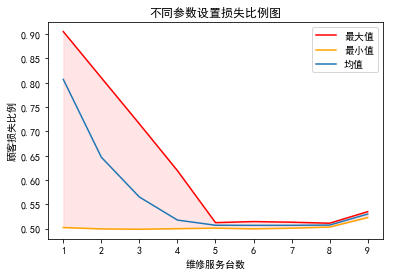

In [102]:
mean = data.groupby(['smt', 'para'], as_index=False).mean()
std = data.groupby(['smt', 'para'], as_index=False).std()
_min = data.groupby(['smt', 'para'], as_index=False).min()
_max = data.groupby(['smt', 'para'], as_index=False).max()
plt.plot(_max.smt, _max.l, c='r')
plt.plot(_min.smt, _min.l, c='orange')
plt.plot(mean.smt, mean.l)
plt.legend(['最大值', '最小值', '均值'])
plt.fill_between(mean.smt, _max.l, _min.l, alpha=0.1, color='r')
plt.title('不同参数设置损失比例图')
plt.xlabel('维修服务台数')
plt.ylabel('顾客损失比例')
#plt.savefig('C:\\Rebalancing\\2020-8-31\\result\\A10M200不同参数设置损失比例图.png',dpi=150)

# Demonstrate the normality of the results

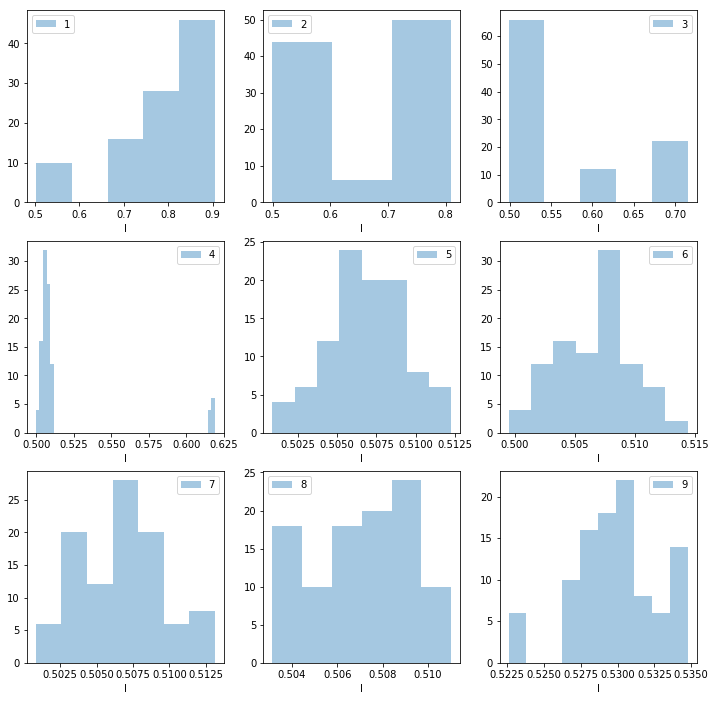

In [76]:
plt.subplots(3,3,figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3, 3,i)
    sb.distplot(data[data.smt==i].l, kde=False)
    plt.legend([i])

# Ranking and Selection

In [69]:
class KNRanking_and_Selection():
    def __init__(self, c, k, n0, ALPHA, m,DELTA, x_add):
        self.c = 1
        # constant
        self.ALPHA = ALPHA
        self.CL = 1 - ALPHA # confidence level
        self.m = m # stop number condition
        self.DELTA = DELTA
        
        self.init_k = k # number of settings
        self.init_n0 = n0
        self.init_Ita = self.get_ita(ALPHA, k, n0)
        def load_X(address):
            X = pd.read_csv(address)
            X['l'] = 1-X['l']
            return np.array([X[X.smt == i]['l'].values for i in range(1,k+1)])
        self.init_X = load_X(x_add)
        
            
    def initialize(self):
        self.k = self.init_k 
        self.n0 = self.init_n0 
        self.Ita = self.init_Ita
        self.I = {} # keep a dict to identify the initial index of each row left in the X
        def get_X(X,n0):
            return X[:,:n0]
        self.X = get_X(self.init_X, self.n0)
        [self.I.update({_:_}) for _ in range(self.k)] 
        #self.X = np.array([np.random.normal(loc=setting[i][0],scale=setting[i][1],size=n0) for i in range(k)])
        self.h2 = self.get_h2(self.c, self.Ita, self.n0)
        self.S2 = self.get_S2(self.X, self.n0, self.k)
        self.Nil = self.get_Nil(self.h2, self.S2, self.DELTA, self.k)
        self.Ni = self.get_Ni(self.Nil)
        self.Xbar = self.get_Xbar(self.X, self.n0)
        
        self.counter = self.n0*k
        #print(self.DELTA,self.Ni)
        #print(self.k, self.n0, self.Ita, self.I, self.X, self.h2, self.S2, self.Nil, self.Ni, self.Xbar)
    
    def initial_check(self):
        if self.n0 > max(self.Ni): 
            t = np.argmax(self.Xbar)
            #print('{} is the best!'.format(t))
            self.I = {t:t}
            #print('initial filter')
            #print(self.Ni)
            #print('-'*36)
            return 1
        else: 
            self.r = self.n0
            return 0
        
    # calc ita
    def get_ita(self, alpha, k , n0):
        return 0.5 * ((2*alpha / (k-1)) ** (-2/(n0-1))-1)
    # calc h2
    def get_h2(self, c, ita, n0):
        return 2 * c * ita * (n0-1)
    # calc S2il
    def get_S2(self, X, n0, k):
        X = X[:,:n0]
        return [[np.var(X[i]-X[l], ddof=1) for l in range(k)] for i in range(k)]
    # calc Nil
    def get_Nil(self, h2, s2, delta, k):
        return [[int(h2 * s2[i][l] / delta ** 2) for l in range(k)] for i in range(k)]
    # calc Ni
    def get_Ni(self, Nil):
        return [max(_) for _ in Nil]
    # calc Xbar
    def get_Xbar(self, X, r):
        return [np.mean(_) for _ in X[:,:r]]
    # calc Wil
    def get_Wil(self, s2, h2, delta, c, r, I_):
        return [[max(0, delta/2/c/r*(h2*s2[i][l]/delta**2 - r)) for l in I_.values()] for i in I_.values()]
    # update X
    def add_X(self, X, addon):
        #[np.append(X[i],v) for i,v in enumerate(addon)]
        return np.c_[X, addon]
    # update r
    def add_r(self, r):
        return r+1
    # delete i from I
    def update_I(self, I, pop):
        new_I = {}
        [new_I.update({n:v}) for n, v in enumerate(set(I.values())-set(pop))]
        return new_I
    def update_X(self, X, pop):
        new_X = X
        new_X = np.delete(new_X, pop, axis=0)
        return new_X
    # check stop condition
    def check_stop(self, I, m):
        if len(I)<=m: return 0
        else: return 1
    # check each I
    def screen(self, I, X, Xbar, Wil):
        pop_I, pop_X = [], []
        for i in I:
            if sum([Xbar[i]>=Xbar[l] - Wil[i][l] for l in I if i!=l]) == len(Wil[0])-1: continue
            else: 
                pop_I.append(I[i])
                #print('remove{}'.format(I[i]))
                pop_X.append(i)
        I = self.update_I(I, pop_I)
        X = self.update_X(X, pop_X)
        return I, X
    # screening
    def screening(self, I, X, Xbar, S2, h2, delta, c, r):
        Wil = self.get_Wil(S2, h2, delta, c, r, I)
        I, X = self.screen(I, X, Xbar, Wil)
        return I, X
    
    def loop_filter(self):
        best = []
        while self.check_stop(self.I, self.m): 
            #if self.r<199: cursor = self.r+1
            #else: cursor = np.random.randint(0,200)
            cursor = np.random.randint(0,200)
            x_addon = [self.init_X[i][cursor] for i in self.I.values()]
            self.counter += len(x_addon)
            self.X, self.r = self.add_X(self.X, x_addon), self.add_r(self.r)
            self.Xbar = self.get_Xbar(self.X, self.r)
            if self.r == 1 + max([self.Ni[i] for i in self.I.values()]):
                best.append(self.I[np.argmax(self.Xbar)])
                print('stopped at here!')
                break
                # 处理m个
            else:
                self.I, self.X = self.screening(self.I, self.X, self.Xbar, self.S2, self.h2, self.DELTA, self.c, self.r)
                #print(self.I)
                self.k = len(self.I)
        best += self.I.values()
        return best

    def main(self):
        self.initialize()
        if not self.initial_check():
            self.loop_filter()
        value = [_ for _ in self.I.values()][0]
        return value, self.counter
        
        

In [60]:
df = pd.read_csv(x_add)

In [58]:
df.groupby(['para']).mean()['l'], df.groupby(['para']).std()['l']

(para
 1    0.674845
 2    0.651146
 3    0.648444
 4    0.647986
 5    0.648063
 6    0.647983
 Name: l, dtype: float64, para
 1    0.001629
 2    0.001518
 3    0.001527
 4    0.001542
 5    0.001577
 6    0.001532
 Name: l, dtype: float64)

# A2M6 r&s

In [163]:
c = 1
k = 45 # number of settings
n0 = 10

# constant
ALPHA = 0.05
CL = 1 - ALPHA # confidence level
DELTA = 0.005

m = 1 # stop number condition
rs = KNRanking_and_Selection(c, k, n0, ALPHA, m, DELTA, x_add)

In [96]:
x_add = 'C:\\Rebalancing\\2020-8-31\\result\\A2M6VNConcat.csv'

In [123]:
df = pd.read_csv(x_add)

In [124]:
df.head()

,Unnamed: 0,l,ls,epi,smt,para,i
0,0,0.440788,0.000138,0,1,1,11
1,1,0.424453,0.000114,0,2,2,12
2,2,0.419267,0.000171,0,3,3,13
3,3,0.414403,0.000110,0,4,4,14
4,4,0.406862,0.000146,0,5,5,15


In [129]:
df.groupby(['smt']).mean()

,Unnamed: 0,l,ls,epi,para,i
smt,,,,,,
1,588.0,0.447729,0.000189,24.5,1.0,11.0
2,589.0,0.425227,0.000216,24.5,2.0,12.0
3,590.0,0.417669,0.000229,24.5,3.0,13.0
4,591.0,0.413602,0.000236,24.5,4.0,14.0
5,592.0,0.411409,0.000232,24.5,5.0,15.0
6,593.0,0.410877,0.000242,24.5,6.0,16.0
7,594.0,0.408498,0.000242,24.5,7.0,17.0
8,595.0,0.408235,0.000213,24.5,8.0,18.0
9,596.0,0.407525,0.000257,24.5,9.0,19.0


In [119]:
d = {}
for i,n in enumerate(set(df.smt.values)):
    d[n]=i+1
d

df.smt = df.smt.map(lambda x: d[x])
df.to_csv(x_add)

In [121]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,inplace=True)

In [122]:
df.to_csv(x_add)

In [164]:
rs = KNRanking_and_Selection(c, k, n0, ALPHA, m, DELTA, x_add)

In [165]:
Macro_run = 1
re = []
for i in tqdm(range(Macro_run)):
    re += rs.main()


re = np.array(re).reshape(-1,2)

[0.5515943220539821, 0.5751337736013387, 0.5824302116356365, 0.586100176494419, 0.5881266922670367, 0.5884228275568785, 0.5907347751173998, 0.5909601591075965, 0.5923737940052455, 0.5605041965186293, 0.5818690246458976, 0.5935684855707282, 0.5926344195669228, 0.5974252184825286, 0.5956016652775628, 0.5964480013265372, 0.5966105523954344, 0.564516329083019, 0.5834719140238019, 0.5900302756723701, 0.5943099852852839, 0.5971284541678191, 0.5994537075080489, 0.5970340169940197, 0.56213884145249, 0.5854930222975416, 0.5918087490416286, 0.5916587536204109, 0.5978584854063903, 0.5999750274292771, 0.5623986202783389, 0.5814221295804569, 0.5900245834862817, 0.5948376938997836, 0.5966193973592271, 0.5629377832855643, 0.5830892965903346, 0.5910185497447903, 0.5944687954503863, 0.5629806654328062, 0.5849194125495853, 0.5932338320353371, 0.5617611389933846, 0.5852358181769234, 0.5615686279358734]
remove1
remove2
remove3
remove4
remove5
remove6
remove7
remove8
remove9
remove10
remove11
remove12
remo

In [177]:
low = [r+1 for r in re[0][0]]

In [186]:
np.unique(df[df.smt.isin(low)][['i', 'smt']])

array([14, 15, 16, 23, 24, 25, 26, 27, 30, 33, 34, 36, 37, 46, 53, 54],
      dtype=int64)

In [86]:
Counter(re[:,0]), np.mean(re[:,1])

(Counter({3: 974, 2: 26}), 104.092)

# save last instances within delta to the best

In [155]:
class KNRanking_and_Selection():
    def __init__(self, c, k, n0, ALPHA, m,DELTA, x_add):
        self.c = 1
        # constant
        self.ALPHA = ALPHA
        self.CL = 1 - ALPHA # confidence level
        self.m = m # stop number condition
        self.DELTA = DELTA
        
        self.init_k = k # number of settings
        self.init_n0 = n0
        self.init_Ita = self.get_ita(ALPHA, k, n0)
        def load_X(address):
            X = pd.read_csv(address)
            X['l'] = 1-X['l']
            return np.array([X[X.smt == i]['l'].values for i in range(1,k+1)])
        self.init_X = load_X(x_add)
        
            
    def initialize(self):
        self.k = self.init_k 
        self.n0 = self.init_n0 
        self.Ita = self.init_Ita
        self.I = {} # keep a dict to identify the initial index of each row left in the X
        def get_X(X,n0):
            return X[:,:n0]
        self.X = get_X(self.init_X, self.n0)
        [self.I.update({_:_}) for _ in range(self.k)] 
        #self.X = np.array([np.random.normal(loc=setting[i][0],scale=setting[i][1],size=n0) for i in range(k)])
        self.h2 = self.get_h2(self.c, self.Ita, self.n0)
        self.S2 = self.get_S2(self.X, self.n0, self.k)
        self.Nil = self.get_Nil(self.h2, self.S2, self.DELTA, self.k)
        self.Ni = self.get_Ni(self.Nil)
        self.Xbar = self.get_Xbar(self.X, self.n0)
        
        self.counter = self.n0*k
        #print(self.DELTA,self.Ni)
        #print(self.k, self.n0, self.Ita, self.I, self.X, self.h2, self.S2, self.Nil, self.Ni, self.Xbar)
    
    def initial_check(self):
        if self.n0 > max(self.Ni): 
            g = max(self.Xbar)
            #print('{} is the best!'.format(t))
            self.tempI = {}
            for i, v in enumerate(self.Xbar):
                if g - v <= self.DELTA:
                    self.tempI[i] = self.I[i]
            self.I = self.tempI
            print('initial filter')
            #print(self.Ni)
            #print('-'*36)
            
            return 1
        else: 
            self.r = self.n0
            return 0
        
    # calc ita
    def get_ita(self, alpha, k , n0):
        return 0.5 * ((2*alpha / (k-1)) ** (-2/(n0-1))-1)
    # calc h2
    def get_h2(self, c, ita, n0):
        return 2 * c * ita * (n0-1)
    # calc S2il
    def get_S2(self, X, n0, k):
        X = X[:,:n0]
        return [[np.var(X[i]-X[l], ddof=1) for l in range(k)] for i in range(k)]
    # calc Nil
    def get_Nil(self, h2, s2, delta, k):
        return [[int(h2 * s2[i][l] / delta ** 2) for l in range(k)] for i in range(k)]
    # calc Ni
    def get_Ni(self, Nil):
        return [max(_) for _ in Nil]
    # calc Xbar
    def get_Xbar(self, X, r):
        return [np.mean(_) for _ in X[:,:r]]
    # calc Wil
    def get_Wil(self, s2, h2, delta, c, r, I_):
        return [[max(0, delta/2/c/r*(h2*s2[i][l]/delta**2 - r)) for l in I_.values()] for i in I_.values()]
    # update X
    def add_X(self, X, addon):
        #[np.append(X[i],v) for i,v in enumerate(addon)]
        return np.c_[X, addon]
    # update r
    def add_r(self, r):
        return r+1
    # delete i from I
    def update_I(self, I, pop):
        new_I = {}
        [new_I.update({n:v}) for n, v in enumerate(set(I.values())-set(pop))]
        return new_I
    def update_X(self, X, pop):
        new_X = X
        new_X = np.delete(new_X, pop, axis=0)
        return new_X
    # check stop condition
    def check_stop(self, I, m):
        if len(I)<=m: 
            print('stopped at m')
            g = max(self.Xbar)
            #print('{} is the best!'.format(t))
            self.tempI = {}
            for i, v in enumerate(self.Xbar):
                if g - v <= self.DELTA:
                    self.tempI[i] = self.preI[i]
            self.I = self.tempI
            return 0
        elif max(self.Xbar) - min(self.Xbar) <= self.DELTA : 
            print(self.Xbar)
            return 0
        else: return 1
    # check each I
    def screen(self, I, X, Xbar, Wil):
        pop_I, pop_X = [], []
        for i in I:
            if sum([Xbar[i]>=Xbar[l] - Wil[i][l] for l in I if i!=l]) == len(Wil[0])-1: continue
            else: 
                pop_I.append(I[i])
                print('remove{}'.format(len(pop_I)))
                pop_X.append(i)
        self.preI = I
        I = self.update_I(I, pop_I)
        X = self.update_X(X, pop_X)
        return I, X
    # screening
    def screening(self, I, X, Xbar, S2, h2, delta, c, r):
        Wil = self.get_Wil(S2, h2, delta, c, r, I)
        I, X = self.screen(I, X, Xbar, Wil)
        return I, X
    
    def loop_filter(self):
        best = []
        while self.check_stop(self.I, self.m): 
            if self.r<49: cursor = self.r+1
            else: np.random.randint(0,50)
            x_addon = [self.init_X[i][cursor] for i in self.I.values()]
            self.counter += len(x_addon)
            self.X, self.r = self.add_X(self.X, x_addon), self.add_r(self.r)
            self.Xbar = self.get_Xbar(self.X, self.r)
            print(self.Xbar)
            if self.r == 1 + max([self.Ni[i] for i in self.I.values()]):
                best.append(self.I[np.argmax(self.Xbar)])
                print('stopped at r!')
                break
                # 处理m个
            else:
                self.I, self.X = self.screening(self.I, self.X, self.Xbar, self.S2, self.h2, self.DELTA, self.c, self.r)
                #print(self.I)
                self.k = len(self.I)
        best += self.I.values()
        return best

    def main(self):
        self.initialize()
        if not self.initial_check():
            self.loop_filter()
        value = [_ for _ in self.I.values()]
        return value, self.counter
        
rs = KNRanking_and_Selection(c, k, n0, ALPHA, m, DELTA, x_add)
rs.main()

[0.5515943220539821, 0.5751337736013387, 0.5824302116356365, 0.586100176494419, 0.5881266922670367, 0.5884228275568785, 0.5907347751173998, 0.5909601591075965, 0.5923737940052455, 0.5605041965186293, 0.5818690246458976, 0.5935684855707282, 0.5926344195669228, 0.5974252184825286, 0.5956016652775628, 0.5964480013265372, 0.5966105523954344, 0.564516329083019, 0.5834719140238019, 0.5900302756723701, 0.5943099852852839, 0.5971284541678191, 0.5994537075080489, 0.5970340169940197, 0.56213884145249, 0.5854930222975416, 0.5918087490416286, 0.5916587536204109, 0.5978584854063903, 0.5999750274292771, 0.5623986202783389, 0.5814221295804569, 0.5900245834862817, 0.5948376938997836, 0.5966193973592271, 0.5629377832855643, 0.5830892965903346, 0.5910185497447903, 0.5944687954503863, 0.5629806654328062, 0.5849194125495853, 0.5932338320353371, 0.5617611389933846, 0.5852358181769234, 0.5615686279358734]
remove1
remove2
remove3
remove4
remove5
remove6
remove7
remove8
remove9
remove10
remove11
remove12
remo

([6,
  7,
  8,
  11,
  12,
  13,
  14,
  15,
  16,
  19,
  20,
  21,
  22,
  23,
  26,
  27,
  28,
  29,
  32,
  33,
  34,
  37,
  38,
  41],
 495)

In [48]:
c = 1
k = 6 # number of settings
n0 = 10

# constant
ALPHA = 0.05
CL = 1 - ALPHA # confidence level
DELTA = 0.001

m = 1 # stop number condition
rs = KNRanking_and_Selection(c, k, n0, ALPHA, m, DELTA, x_add)

In [49]:
Macro_run = 1000
re = []
for i in tqdm(range(Macro_run)):
    re += rs.main()


re = np.array(re).reshape(-1,2)

In [50]:
re

array([[list([2, 3, 4, 5]), 70],
       [list([2, 3, 4, 5]), 70],
       [list([2, 3, 4, 5]), 70],
       ...,
       [list([2, 3, 4, 5]), 70],
       [list([2, 3, 4, 5]), 70],
       [list([2, 3, 4, 5]), 70]], dtype=object)